In [1]:
import pandas as pd
import csv
from matplotlib import pyplot as plt
import os
import numpy as np
from scipy import stats


In [2]:
R=6.2

In [3]:
folder_list=list()
current_folder = os.getcwd()
for item in os.listdir(current_folder):
    if len(item) <= 3:
        folder_list.append(item)
folder_list.sort(key=lambda x:int(x.replace("G","")))

In [4]:
csv_list=list()
for folder in folder_list:
    folder_path=os.path.join(current_folder,folder)
    csv_list.append(os.listdir(folder_path))
gain_list=list()
for folder in folder_list:
    gain_list.append(int(folder.replace("G","")))

In [5]:
sum=0
for csv_file in csv_list:
    sum+=len(csv_file)
print(sum)

52


In [6]:
I_mm = list()
I_adc = list()
G = list()
G_LSB = list()

In [7]:
for i in range(len(csv_list)):
    for csv_file in csv_list[i]:

        G.append(gain_list[i])
        G_LSB.append(4096/2**15/gain_list[i])
        splitted_I = csv_file.replace(".csv", "").split(" ")
        I_mm.append(float(splitted_I[0]) +
                float(splitted_I[1])/(10**len(splitted_I[1])))

        folder_path=os.path.join(current_folder,folder_list[i])
        with open(os.path.join(folder_path,csv_file), "r") as f:
            csv_reader = csv.reader(f, delimiter=',')
            I_adc_temp = list()
            for row in csv_reader:
                # cek kalo list kosong atau engga
                if row:
                    I_adc_temp.append(float(row[0]))
        I_adc.append(np.average(I_adc_temp))

In [8]:
Idata = pd.DataFrame([I_mm, I_adc, G, G_LSB]).T
Idata.columns = ['I multimeter', 'I ADC', 'G', 'G LSB']
Idata=Idata.sort_values(["G","I multimeter"]).reset_index(drop=True)
#Idata = Idata.sort_values(['G','I ADC'])
#Idata['I ADC'] = Idata['I ADC']*3/6.2/1000

In [9]:
(2**15-1)*0.16275057+0.36042472845584683

5333.208351918456

In [10]:
Idata['I ADC (mV)'] = Idata['I ADC'].multiply(Idata['G LSB'], axis="index")

\begin{equation*}
  V_{adc}=I_{in}R_{shunt}\frac{1}{3}A_v
\end{equation*}
\begin{equation*}
    I_{in}=\frac{3V_{adc}}{R_{shunt}A_v}
\end{equation*}


In [11]:
Slope_I = list()
Inter_I = list()
for gain in gain_list:
    reg_result= stats.linregress(Idata['I ADC (mV)'].loc[Idata['G']==gain], Idata['I multimeter'].loc[Idata['G']==gain])
    Slope_I.append(reg_result.slope)
    Inter_I.append(reg_result.intercept)


In [12]:
Slope_arr= list()
Inter_arr= list()
#reg_pred = list()
for i in range(len(csv_list)):
    for j in csv_list[i]:
        Slope_arr.append(Slope_I[i])
        Inter_arr.append(Inter_I[i])

In [13]:
Idata['I pred']=Idata['I ADC (mV)'].multiply(Slope_arr)+Inter_arr

In [14]:
E_arr=list()
for i in range(len(Idata)):
    E_arr.append(abs(Idata['I pred'][i]-Idata['I multimeter'][i])/Idata['I multimeter'][i]*100)
Idata['Error']=E_arr

In [15]:
for i in gain_list:
    print(np.average(Idata["Error"].loc[Idata['G']==i]))

2.935547454022666
0.657992336031211
3.2079590624009997
3.2012774629880374


In [16]:
Idata.iloc[0]['I ADC']*Idata.iloc[0]['G LSB']*Slope_I[0]+Inter_I[0]

18.67423999837945

In [17]:
Idata.iloc[0]

I multimeter       20.200000
I ADC           13077.510000
G                   2.000000
G LSB               0.062500
I ADC (mV)        817.344375
I pred             18.674240
Error               7.553267
Name: 0, dtype: float64

In [18]:
gain_list

[2, 4, 8, 16]

In [19]:
gain_list_LSB=list()
for i in gain_list:
    gain_list_LSB.append(4096/2**15/i)

In [20]:
Inter_I

[-1.557088705010358, 1.5838729569280119, -5.69417804694308, -4.169697893371396]

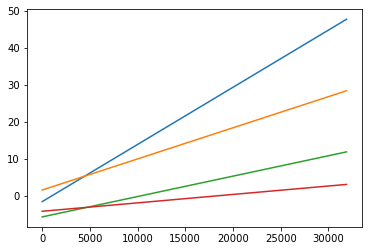

In [21]:
for i in range(len(gain_list)):
    x=np.array(range(0,32000,100))
    y=Slope_I[i]*x*gain_list_LSB[i]+Inter_I[i]
    plt.plot(x,y)

In [22]:
import plotly as ply

In [23]:
fig = ply.graph_objects.Figure()
# Create and style traces
fig.add_trace(ply.graph_objects.Scatter(
    x=Idata["I multimeter"].loc[Idata['G'] == 16.0], y=Idata["Error"].loc[Idata['G'] == 16.0],name="16x"))
fig.add_trace(ply.graph_objects.Scatter(
    x=Idata["I multimeter"].loc[Idata['G'] == 8.0], y=Idata["Error"].loc[Idata['G'] == 8.0],name="8x"))
fig.add_trace(ply.graph_objects.Scatter(
    x=Idata["I multimeter"].loc[Idata['G'] == 4.0], y=Idata["Error"].loc[Idata['G'] == 4.0],name="4x"))
fig.add_trace(ply.graph_objects.Scatter(
    x=Idata["I multimeter"].loc[Idata['G'] == 2.0], y=Idata["Error"].loc[Idata['G'] == 2.0],name="2x"))
fig.update_layout(title='Error Pengukuran arus pada setiap gain',
                  xaxis_title='Arus (mA)',
                  yaxis_title='Error (%)')
